# Custom Models and Likelihoods

By fitting a basic lightcurve model, we demonstrate how to build a custom model and likelihood in RadVel versions 1.40 and later. Note that this is different from previous versions, now that parameters are stored in a ``radvel.Vector`` object.


Perform some preliminary imports:

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood

import batman

We begin by generating artifical transit data using the batman package:

In [17]:
x = np.sort(np.random.uniform(low=-.1,high=.3,size=100))
yerr = 4e-3 #assuming we know the Gaussian uncertainty

p = batman.TransitParams()
p.t0 = 0.1
p.per = 8.31
p.rp = .24
p.a = 14.33
p.inc = 91.0
p.ecc = 0.0
p.w = 168.0
p.limb_dark = 'uniform'
p.u = []

m = batman.TransitModel(p, x)
y = m.light_curve(p)
y += yerr * np.random.randn(len(y))

Now we prepare for our analyis of the lightcurve. We can begin by defining the parameters that will be used in our model:

In [18]:
params = radvel.Parameters(num_planets=1)
params['t0'] = radvel.Parameter(value=0.0)
params['per'] = radvel.Parameter(value=8.31, vary=False) #assuming period is known
params['rp'] = radvel.Parameter(value=0.15)
params['a'] = radvel.Parameter(value=20)
params['inc'] = radvel.Parameter(value=90)
params['ecc'] = radvel.Parameter(value=0.0, vary=False, linear=False) #for simplicity, we assume a circular orbit
params['w'] = radvel.Parameter(value=150)
params['jit'] = radvel.Parameter(value=.01)

Next, we need to set up a dictionary that tells RadVel how to construct the vector that holds our parameter values. Each key should correspond to an index in the vector.

In [19]:
indices = {
    't0': 0,
    'per': 1,
    'rp': 2,
    'a': 3,
    'inc': 4,
    'ecc': 5,
    'w': 6,
    'dvdt': 7,
    'curv': 8,
    'jit': 9
}

Using the indices defined above, we will now provide a function that defines the lightcurve signal as a function of time and parameters:

In [20]:
def lightcurve_calc(t, pars, vector):
    
    pars = batman.TransitParams()
    pars.t0 = vector.vector[0][0]
    pars.per = vector.vector[1][0]
    pars.rp = vector.vector[2][0]
    pars.a = vector.vector[3][0]
    pars.inc = vector.vector[4][0]
    pars.ecc = vector.vector[5][0]
    pars.w = vector.vector[6][0]
    pars.limb_dark = "quadratic" 
    pars.u = [vector.vector[7][0], vector.vector[8][0]]

    m = batman.TransitModel(pars, t)

    flux = m.light_curve(pars)
    return flux

Using the function that defines our model, we can now construct a `radvel.GeneralRVModel` object. Afterwards, you must overwrite the default vector construction by redefining `radvel.GeneralRVModel.vector.indices` and calling `radvel.GeneralRVModel.vector.dict_to_vector()`.

In [21]:
mod = radvel.GeneralRVModel(params, forward_model=lightcurve_calc)
mod.vector.indices = indices
mod.vector.dict_to_vector()

We can now plot the data and initial model. When using custom parameters and models, built in plotting functions will rarely work.

Text(0.5, 1.0, 'Initial Transit Model and Data')

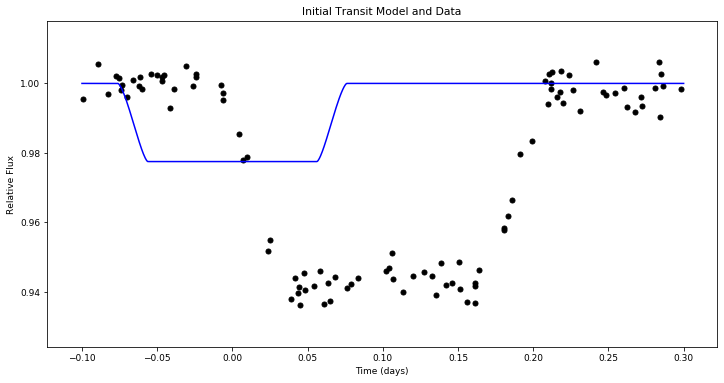

In [22]:
t = np.linspace(-0.1, 0.3, 1000)
plt.figure(figsize=(12,6))
plt.scatter(x, y, c='black')
plt.plot(t, mod(t), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Initial Transit Model and Data')

Now that the model is ready, we need to set up a likelihood object that works for transit fitting. First, we construct a new class based on the generic `radvel.Likelihood` object and defining it's logprob function. Then we can initialize the likelihood.

In [23]:
class TransitLikelihood(radvel.Likelihood):
    
    def logprob(self):
        sigma_jit = self.vector.vector[self.vector.indices['jit']][0]
        resid = self.residuals()
        loglike = radvel.likelihood.loglike_jitter(resid, self.yerr, sigma_jit)
        return loglike

errors = np.zeros(len(x))
errors.fill(yerr)
like = TransitLikelihood(mod, x, y, errors)

Now we are ready to initialize the `radvel.Posterior` object. Note that most built in priors may be used on custom parameters.

In [24]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian('inc',90,3)]
post.priors += [radvel.prior.Gaussian('w',160,10)]
post.priors += [radvel.prior.HardBounds('rp',0,1)] #priors are useful to keep params in physically possible boundaries
post.priors += [radvel.prior.HardBounds('a',5,30)]

Maximize the likelihood, print the updated posterior object, and plot the newly fitted model:

In [25]:
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method='Nelder-Mead',
    )

print(post)

parameter                     value      vary
t0                         0.100425       True
per                            8.31      False
rp                         0.240966       True
a                           15.3864       True
inc                         90.1444       True
ecc                               0      False
w                           108.551       True
jit                      0.00296493       True

Priors
------
Gaussian prior on inc, mu=90, sigma=3
Gaussian prior on w, mu=160, sigma=10
Bounded prior on rp, min=0, max=1
Bounded prior on a, min=5, max=30



Text(0.5, 1.0, 'Maximized Transit Model and Data')

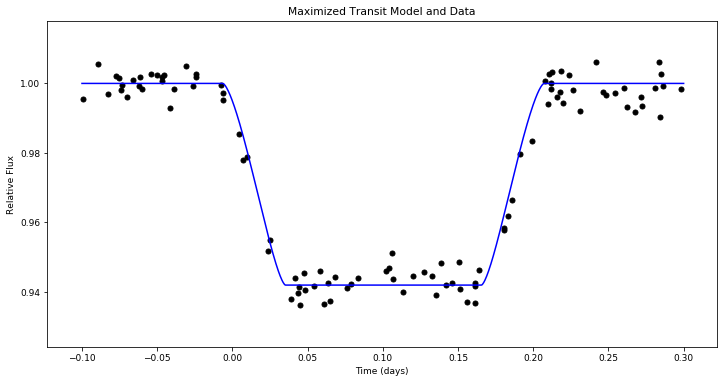

In [26]:
plt.figure(figsize=(12,6))
plt.scatter(x, y, c='black')
plt.plot(t, post.model(t), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Maximized Transit Model and Data')

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties. In this example we will run 500 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers.

In [27]:
df = radvel.mcmc(post,nwalkers=50,nrun=500)

20000/200000 (10.0%) steps complete; Running 17098.31 steps/s; Mean acceptance rate = 32.9%; Min Auto Factor =  17; Max Auto Relative-Change =   inf; Min Tz = 1619.0; Max G-R = 1.018
Discarding burn-in now that the chains are marginally well-mixed

200000/200000 (100.0%) steps complete; Running 17407.66 steps/s; Mean acceptance rate = 27.9%; Min Auto Factor =  16; Max Auto Relative-Change = 0.202; Min Tz = 350.8; Max G-R = 1.091

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Let's take a quick look at the parameter values and uncertainties. Additionally, we need to update the posterior for future plotting and other purposes.

In [28]:
quants = df.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

par_array = []
for par in post.name_vary_params():
    med = quants[par][0.5]
    high = quants[par][0.841] - med
    low = med - quants[par][0.159]
    err = np.mean([high,low])
    err = radvel.utils.round_sig(err)
    par_array.append(med) 
    med, err, errhigh = radvel.utils.sigfig(med, err)
    print('{} : {} +/- {}'.format(par, med, err))
post.set_vary_params(par_array)

t0 : 0.1007 +/- 0.0018
rp : 0.24 +/- 0.0039
a : 15 +/- 2
inc : 90 +/- 28
w : 152 +/- 25
jit : 0.0019 +/- 0.0047


Let's make a corner plot to display the posterior distributions:

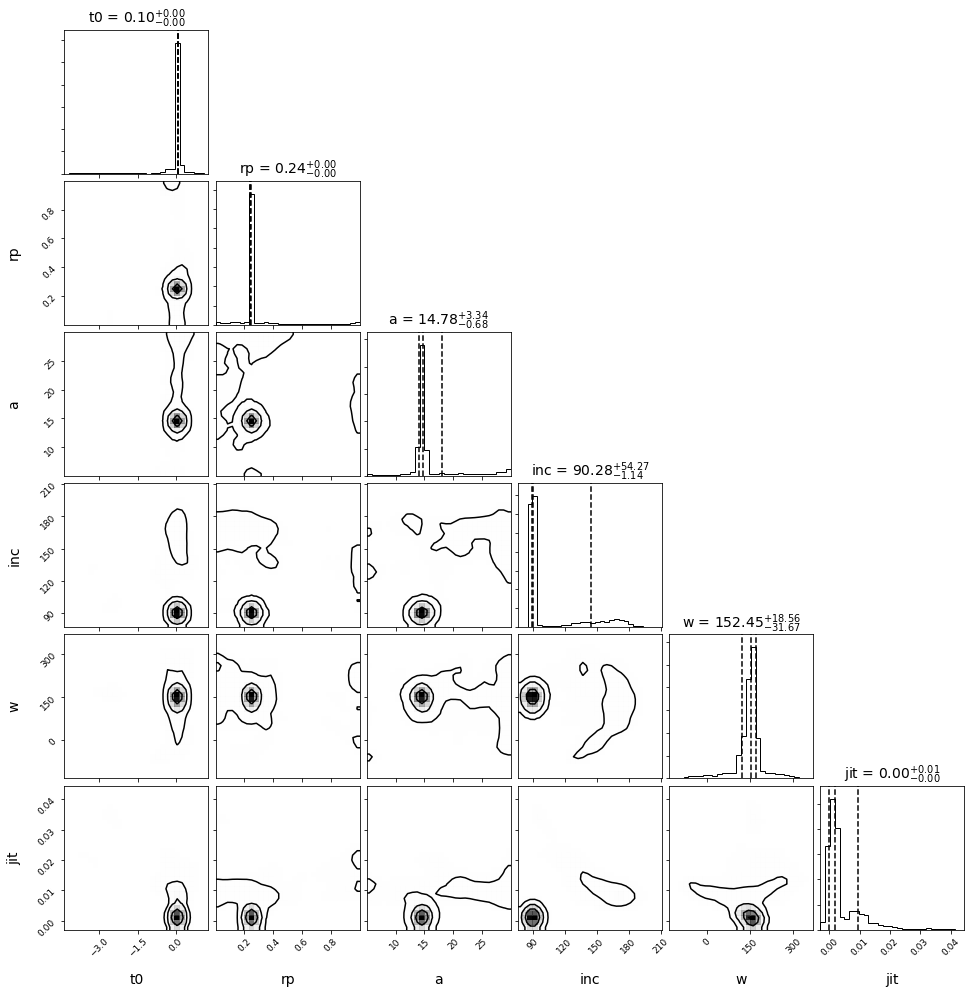

In [29]:
_ = corner.corner(df[post.name_vary_params()], labels=post.name_vary_params(), label_kwargs={"fontsize": 14},
            plot_datapoints=False, bins=30, quantiles=[0.16, 0.5, 0.84],
            show_titles=True, title_kwargs={"fontsize": 14}, smooth=True
        )

Finally, we can plot our MCMC model and data.

Text(0.5, 1.0, 'Final Transit Model and Data')

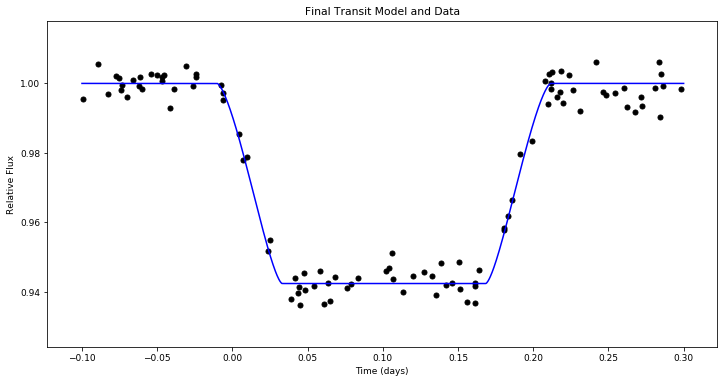

In [30]:
plt.figure(figsize=(12,6))
plt.scatter(x, y, c='black')
plt.plot(t, post.model(t), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Final Transit Model and Data')